In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as rt
import pandas as pd
from tqdm import tqdm

from calibration.color_transformation.model_filename import compose_model_filename

In [2]:
INPUT_BANDS = list('grizy')
OUTPUT_BAND = 'r'
INPUT_SURVEY = 'PS1'
OUTPUT_SURVEY = 'DES'

model_filename = compose_model_filename(input_survey=INPUT_SURVEY, output_survey=OUTPUT_SURVEY, output_band=OUTPUT_BAND, input_bands=INPUT_BANDS)
model_dir = Path(f'models/phot-transformation')

MAG_MODEL = model_dir / model_filename
VAR_MODEL = model_dir / f'var_{model_filename}'
assert MAG_MODEL.exists()
assert VAR_MODEL.exists()

DATAPATH = Path('data/ps1_stars.parquet')

SUBSAMPLE = 1_000_000

In [37]:
def apply_model_in_batches(session, data, batch_size=1<<20):
    result = []
    for i_batch in tqdm(range(0, len(data), batch_size)):
        batch = data[i_batch:i_batch + batch_size]
        result.append(session.run([session.get_outputs()[0].name], {session.get_inputs()[0].name: batch})[0].squeeze())
    return np.concatenate(result)


def simulate_variance(session, data, errors, batch_size=1<<20, rng=0, n_samples=1_000):
    rng = np.random.default_rng(rng)
    deltas = rng.normal(loc=0, scale=1, size=(n_samples, data.shape[1])).astype(np.float32)

    actual_batch_size = max(1, batch_size // n_samples)

    result = []
    for i_batch in tqdm(range(0, len(data), actual_batch_size)):
        batch_data = data[i_batch:i_batch + actual_batch_size]
        batch_errors = errors[i_batch:i_batch + actual_batch_size]
        # first axis is object, second is random sample, third is band
        batch_X = batch_data[:, None, :] + batch_errors[:, None, :] * deltas[None, :, :]

        batch_y = session.run(
            [session.get_outputs()[0].name], {session.get_inputs()[0].name: batch_X.reshape(-1, batch_data.shape[1])}
        )[0].reshape(batch_data.shape[0], n_samples)

        result.append(np.var(batch_y, axis=1))
    return np.concatenate(result)

In [32]:
mag_session = rt.InferenceSession(MAG_MODEL, providers=rt.get_available_providers())
var_session = rt.InferenceSession(VAR_MODEL, providers=rt.get_available_providers())

mag_column_names = [f'{INPUT_SURVEY.lower()}_mag_{band}' for band in INPUT_BANDS]
magerr_column_names = [f'{INPUT_SURVEY.lower()}_magerr_{band}' for band in INPUT_BANDS]
df = pd.read_parquet(DATAPATH, columns=mag_column_names + magerr_column_names)

if SUBSAMPLE is not None:
    df = df.sample(SUBSAMPLE, random_state=0)

mag = df[mag_column_names].to_numpy(dtype=np.float32)
magerr = df[magerr_column_names].to_numpy(dtype=np.float32)

In [ ]:
predicted_var = apply_model_in_batches(var_session, mag)
simulated_var = simulate_variance(mag_session, mag, magerr, n_samples=10_000)

 83%|████████▎ | 7940/9616 [07:08<01:31, 18.29it/s]

(array([   569.,    608.,    617.,    667.,    716.,    764.,    847.,
           843.,    956.,   1043.,   1213.,   1274.,   1308.,   1488.,
          1587.,   1704.,   1887.,   2090.,   2247.,   2453.,   2765.,
          3047.,   3385.,   3622.,   4196.,   4503.,   5246.,   5835.,
          6646.,   7594.,   8586.,   9845.,  11158.,  12861.,  14519.,
         17250.,  20007.,  22926.,  26791.,  31436.,  36533.,  42379.,
         49273.,  57649.,  67745.,  83083., 107234., 143404., 145601.]),
 array([0.10149474, 0.11970271, 0.13791067, 0.15611864, 0.1743266 ,
        0.19253456, 0.21074253, 0.22895049, 0.24715846, 0.26536642,
        0.28357439, 0.30178235, 0.31999032, 0.33819828, 0.35640625,
        0.37461421, 0.39282218, 0.41103014, 0.4292381 , 0.44744607,
        0.46565403, 0.483862  , 0.50206996, 0.52027793, 0.53848589,
        0.55669386, 0.57490182, 0.59310979, 0.61131775, 0.62952572,
        0.64773368, 0.66594165, 0.68414961, 0.70235757, 0.72056554,
        0.7387735 , 0.756

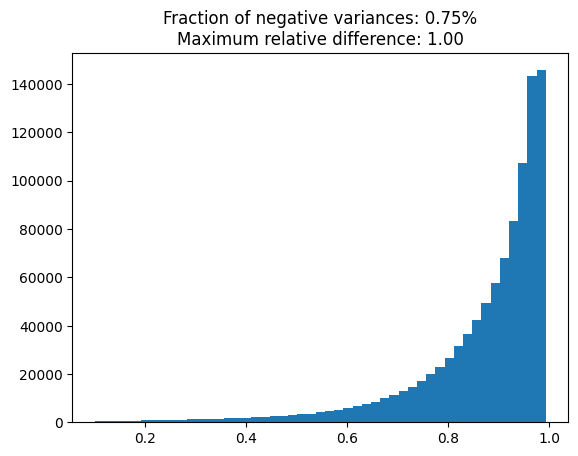

In [45]:
assert np.all(predicted_var > 0)
assert np.all(simulated_var > 0)

diff = (predicted_var - simulated_var) / predicted_var
bellow_zero = np.mean(diff <= 0)
plt.title(f'Fraction of negative variances: {bellow_zero:.2%}\nMaximum relative difference: {np.max(diff):.2f}')
plt.hist(diff, bins=np.linspace(*np.quantile(diff, [0.01, 0.99])))

In [43]:
1

1

In [44]:
1

1